In [44]:
import os

class Config():
    root_path = '/home/jovyan'
    input_path = os.path.join(root_path, 'data')
    model_path = os.path.join(root_path, 'model')
    result_path = os.path.join(root_path, 'result')
    seed = 42

In [45]:
# create dirs

for dir in [Config.model_path, Config.result_path]:
    os.makedirs(dir, exist_ok=True)

In [46]:
import pandas as pd
import numpy as np
import random
import matplotlib.pylab as plt
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold, TimeSeriesSplit
import lightgbm as lgb

In [47]:
pd.set_option('max_columns', 50)
plt.style.use('bmh')

In [48]:
def seed_everything(seed=2021):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(Config.seed)

In [49]:
train_df = pd.read_csv(os.path.join(Config.input_path, 'train_data.csv'))
print(train_df.shape)

(420, 3279)


In [50]:
display(train_df)
train_df.info()

,Date,VGSH,JEF,IVZ,KTCC,FBZ,PLOW,JBK,IAC,IVR,VSH,VCV,OKE,ROK,FTAG,BRKR,GSK,JPS,SRPT,VMI,IMKTA,BDR,JAKK,MVC,AMSF,...,FRAF,HWCC,WYND,CHMG,EVC,NNA,IOR,ATLC,STWD,TTM,NOC,EQS,MKC,MXL,NEV,ASFI,JTA,MNR,TFSL,GTN,TYG,VIRC,BIS,WOOD,MASI
0,2011/11/13,55.942184,17.649006,13.770864,4.77,13.818835,10.198389,12.440549,38.484608,4.836254,8.575465,7.877108,23.100210,59.334507,84.253273,11.731660,28.273636,4.168243,4.860000,75.028809,12.110400,1.13,18.456266,7.713052,15.194721,...,10.988591,9.748321,10.293147,17.453051,1.078169,33.496590,1.92,3.16,6.810544,15.831424,47.542465,2.21,40.948685,4.960000,8.450615,3.721562,4.747546,5.567790,7.262252,1.800000,20.079035,1.504111,826.767029,30.918266,18.430309
1,2011/11/20,55.978844,16.270664,12.719761,4.94,12.744166,10.035272,12.065370,36.252533,4.658076,7.657301,7.939425,22.540537,55.720310,78.528595,11.262002,27.104542,4.072667,4.080000,69.938858,11.282884,1.14,17.461733,6.991731,14.490328,...,11.137086,8.741022,10.082382,17.491066,0.787348,30.493443,1.67,3.59,6.498439,15.531258,45.167881,2.13,40.328121,4.750000,8.548306,3.590744,4.549112,5.473421,7.125532,1.560000,19.711763,1.474619,769.836304,29.410889,17.534525
2,2011/11/27,56.021038,18.813454,14.402946,4.82,13.918125,10.510439,12.285713,39.479744,4.966706,8.611118,7.895799,24.103556,62.140919,86.219765,12.494853,28.854912,4.194794,4.140000,77.642067,11.935346,1.30,18.131134,7.687744,15.919237,...,10.877216,9.606801,10.986426,17.529097,1.078169,31.764000,1.41,4.01,6.609905,17.787354,48.186409,2.16,41.458744,5.040000,8.542193,3.608788,4.851724,5.372760,7.616116,1.700000,20.698137,1.572927,672.212830,31.723339,19.631044
3,2011/12/4,56.002697,18.425301,14.758045,4.73,13.994051,10.652282,12.148743,38.856613,4.680348,8.406092,8.020435,24.216650,64.514320,84.865067,12.543774,29.168411,4.242582,4.260000,78.552612,11.911480,1.20,18.427580,7.776327,15.751523,...,10.505982,10.331058,11.053847,17.529097,1.255500,35.575687,1.34,4.20,6.914577,17.467821,47.687542,2.15,42.325817,4.990000,8.603259,3.541123,4.931097,5.498586,7.350718,1.740000,20.010817,1.779373,694.906921,31.577734,19.383274
4,2011/12/11,56.030224,17.676432,13.664331,4.55,13.445042,10.449807,12.053457,38.624111,4.772620,7.719699,8.093348,23.796175,59.834167,78.047913,12.015410,29.318626,4.218707,3.360000,77.787766,11.959218,1.20,16.680910,7.453629,15.590522,...,9.392272,10.938766,10.676907,18.213341,1.253447,33.535820,1.21,4.07,7.078062,15.434427,47.061852,2.36,41.450233,4.420000,8.647264,3.577211,4.734335,5.662159,6.956642,1.740000,20.336115,1.297665,702.928040,30.412945,18.201599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,2019/10/27,60.417824,18.853819,16.638926,5.97,15.280874,48.024773,29.000000,229.559998,13.800565,19.919037,12.267098,69.389030,175.786072,23.214308,50.016430,44.146408,9.796548,88.570000,140.061996,39.680740,0.74,0.750000,8.715376,64.828636,...,36.151554,4.400000,45.591866,42.605923,2.725922,7.055537,12.11,7.90,23.040262,12.380000,349.537994,1.54,160.050476,19.730000,14.314283,6.950000,11.057277,14.815565,19.043219,16.830000,17.788372,4.010000,16.251677,64.136101,147.509995
416,2019/11/3,60.288853,19.238792,17.527559,6.23,14.581332,51.991562,30.000000,219.949997,14.149504,19.444067,12.296587,69.616211,176.918304,23.952219,47.820099,43.317501,9.757671,96.279999,141.719605,42.919373,0.65,0.860000,8.892039,66.101273,...,36.201164,4.050000,48.119343,45.152054,2.812004,6.169072,11.80,6.94,22.917458,11.860000,347.532867,1.56,159.113876,20.299999,14.373148,10.100000,11.200258,14.385562,19.189333,19.980000,17.243061,4.090000,16.082491,65.034508,142.949997
417,2019/11/10,60.397987,18.967628,17.163631,5.96,14.726692,52.336071,28.500000,221.820007,13.913970,19.325327,12.299479,70.416283,199.254456,23.493517,49.397461,43.482349,9.830559,97.459999,140.945389,43.836159,0.65,0.900000,8.842966,64.927116,...,35.715038,4.010000,4

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Columns: 3279 entries, Date to MASI
dtypes: float64(3278), object(1)
memory usage: 10.5+ MB


In [51]:
print('NaNの合計:', train_df.isnull().sum().sum())
print('NaNを含む行', train_df.index[train_df.isnull().any(axis=1)].to_list())

NaNの合計: 3279
NaNを含む行 [419]


In [52]:
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df = train_df.dropna().set_index('Date')
display(train_df)
train_df.info()

,VGSH,JEF,IVZ,KTCC,FBZ,PLOW,JBK,IAC,IVR,VSH,VCV,OKE,ROK,FTAG,BRKR,GSK,JPS,SRPT,VMI,IMKTA,BDR,JAKK,MVC,AMSF,APTO,...,FRAF,HWCC,WYND,CHMG,EVC,NNA,IOR,ATLC,STWD,TTM,NOC,EQS,MKC,MXL,NEV,ASFI,JTA,MNR,TFSL,GTN,TYG,VIRC,BIS,WOOD,MASI
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-11-13,55.942184,17.649006,13.770864,4.77,13.818835,10.198389,12.440549,38.484608,4.836254,8.575465,7.877108,23.100210,59.334507,84.253273,11.731660,28.273636,4.168243,4.860000,75.028809,12.110400,1.13,18.456266,7.713052,15.194721,2.88,...,10.988591,9.748321,10.293147,17.453051,1.078169,33.496590,1.92,3.16,6.810544,15.831424,47.542465,2.21,40.948685,4.960000,8.450615,3.721562,4.747546,5.567790,7.262252,1.800000,20.079035,1.504111,826.767029,30.918266,18.430309
2011-11-20,55.978844,16.270664,12.719761,4.94,12.744166,10.035272,12.065370,36.252533,4.658076,7.657301,7.939425,22.540537,55.720310,78.528595,11.262002,27.104542,4.072667,4.080000,69.938858,11.282884,1.14,17.461733,6.991731,14.490328,2.52,...,11.137086,8.741022,10.082382,17.491066,0.787348,30.493443,1.67,3.59,6.498439,15.531258,45.167881,2.13,40.328121,4.750000,8.548306,3.590744,4.549112,5.473421,7.125532,1.560000,19.711763,1.474619,769.836304,29.410889,17.534525
2011-11-27,56.021038,18.813454,14.402946,4.82,13.918125,10.510439,12.285713,39.479744,4.966706,8.611118,7.895799,24.103556,62.140919,86.219765,12.494853,28.854912,4.194794,4.140000,77.642067,11.935346,1.30,18.131134,7.687744,15.919237,2.40,...,10.877216,9.606801,10.986426,17.529097,1.078169,31.764000,1.41,4.01,6.609905,17.787354,48.186409,2.16,41.458744,5.040000,8.542193,3.608788,4.851724,5.372760,7.616116,1.700000,20.698137,1.572927,672.212830,31.723339,19.631044
2011-12-04,56.002697,18.425301,14.758045,4.73,13.994051,10.652282,12.148743,38.856613,4.680348,8.406092,8.020435,24.216650,64.514320,84.865067,12.543774,29.168411,4.242582,4.260000,78.552612,11.911480,1.20,18.427580,7.776327,15.751523,2.28,...,10.505982,10.331058,11.053847,17.529097,1.255500,35.575687,1.34,4.20,6.914577,17.467821,47.687542,2.15,42.325817,4.990000,8.603259,3.541123,4.931097,5.498586,7.350718,1.740000,20.010817,1.779373,694.906921,31.577734,19.383274
2011-12-11,56.030224,17.676432,13.664331,4.55,13.445042,10.449807,12.053457,38.624111,4.772620,7.719699,8.093348,23.796175,59.834167,78.047913,12.015410,29.318626,4.218707,3.360000,77.787766,11.959218,1.20,16.680910,7.453629,15.590522,2.16,...,9.392272,10.938766,10.676907,18.213341,1.253447,33.535820,1.21,4.07,7.078062,15.434427,47.061852,2.36,41.450233,4.420000,8.647264,3.577211,4.734335,5.662159,6.956642,1.740000,20.336115,1.297665,702.928040,30.412945,18.201599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-20,60.317860,18.666267,16.484234,6.10,14.971986,44.943859,28.510000,226.830002,13.591201,18.058741,12.090170,69.747047,175.469528,22.965014,43.657055,42.732399,9.709079,85.750000,135.198379,40.238781,0.72,0.850000,8.656488,58.870853,2.07,...,35.155666,4.260000,44.804459,41.976761,2.486806,7.326904,12.08,8.00,22.908010,10.490000,342.460480,1.62,158.804993,18.730000,13.990520,6.680000,10.895230,14.336699,18.526958,16.570000,17.703754,3.960000,17.644960,63.487255,143.740005
2019-10-27,60.417824,18.853819,16.638926,5.97,15.280874,48.024773,29.000000,229.559998,13.800565,19.919037,12.267098,69.389030,175.786072,23.214308,50.016430,44.146408,9.796548,88.570000,140.061996,39.680740,0.74,0.750000,8.715376,64.828636,2.15,...,36.151554,4.400000,45.591866,42.605923,2.725922,7.055537,12.11,7.90,23.040262,12.380000,349.537994,1.54,160.050476,19.730000,14.314283,6.950000,11.057277,14.815565,19.043219,16.830000,17.788372,4.010000,16.251677,64.136101,147.509995
2019-11-03,60.288853,19.238792,17.527559,6.23,14.581332,51.991562,30.000000,219.949997,14.149504,19.444067,12.296587,69.616211,176.918304,23.952219,47.820099,43.317501,9.757671,96.279999,141.7196

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 419 entries, 2011-11-13 to 2019-11-17
Columns: 3278 entries, VGSH to MASI
dtypes: float64(3278)
memory usage: 10.5 MB


In [53]:
train_df = train_df.apply(np.log1p)

<AxesSubplot:xlabel='Date'>

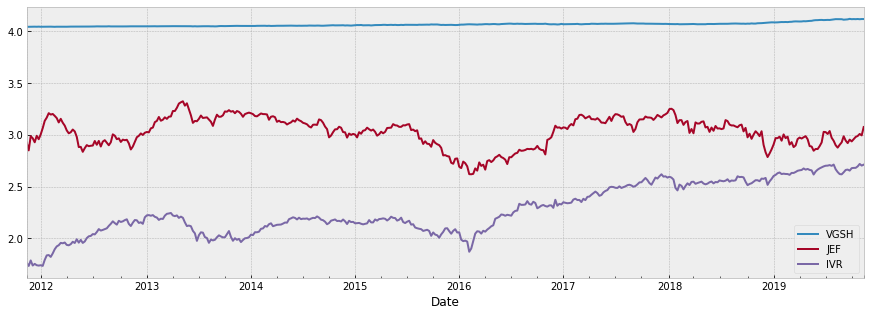

In [54]:
cols = ['VGSH', 'JEF', 'IVR']
train_df[cols].plot(figsize=(15,5))

array([<AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>], dtype=object)

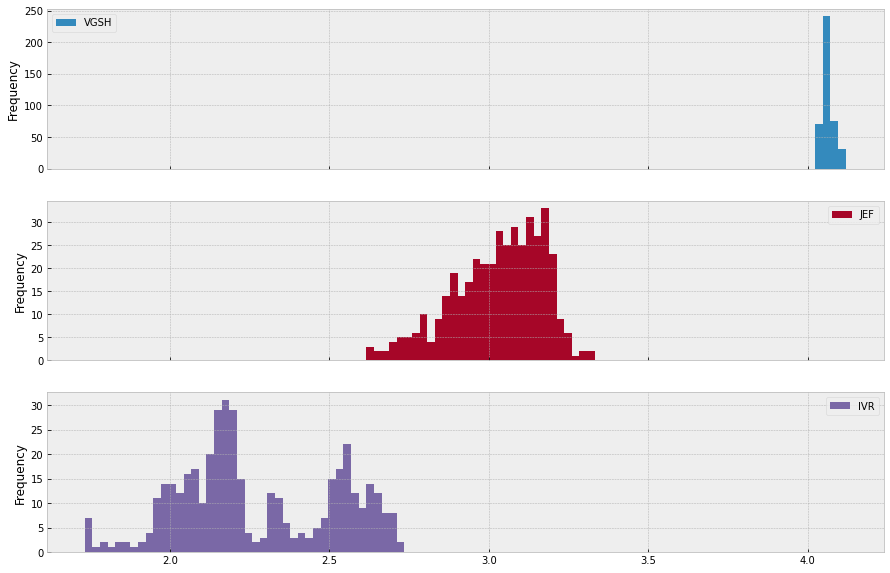

In [55]:
train_df[cols].plot(
    subplots=True, kind='hist', bins=100,
    figsize=(15,10)
)

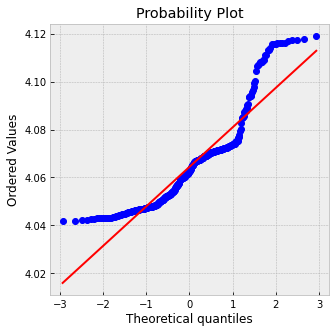

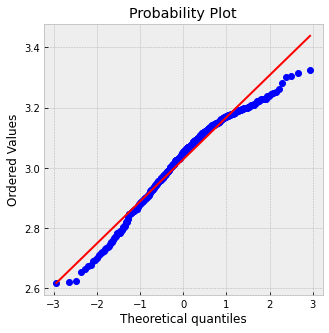

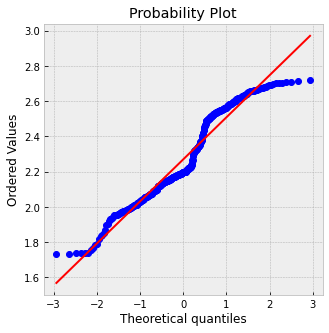

In [56]:
def qqplot(dist):
    plt.figure(figsize=(5,5))
    stats.probplot(dist, dist='norm', plot=plt)
    plt.show()

for col in cols:
    qqplot(train_df[col])

<AxesSubplot:xlabel='Date'>

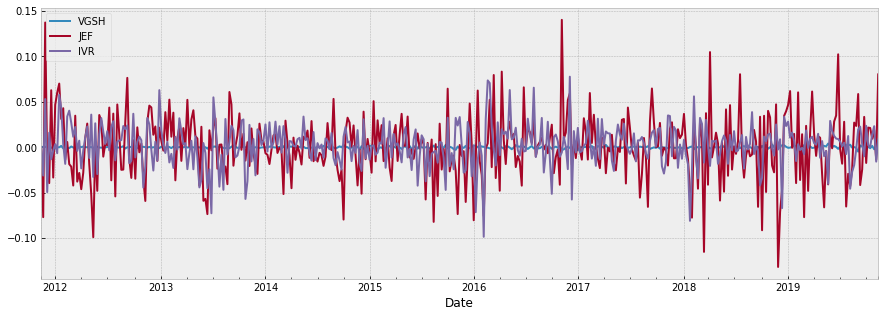

In [57]:
train_df[cols].diff(1).fillna(0).plot(figsize=(15,5))

array([<AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>], dtype=object)

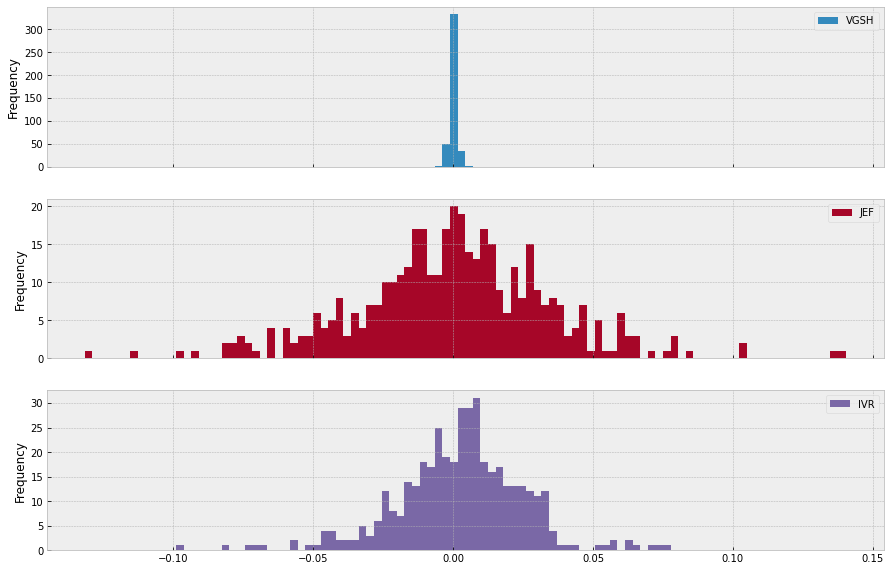

In [58]:
train_df[cols].diff(1).fillna(0).plot(
    subplots=True, kind='hist', bins=100,
    figsize=(15,10)
)

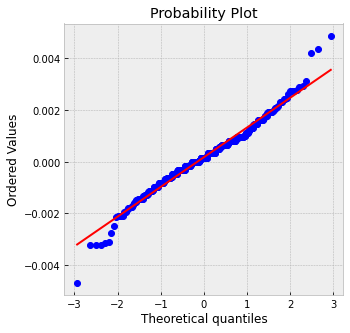

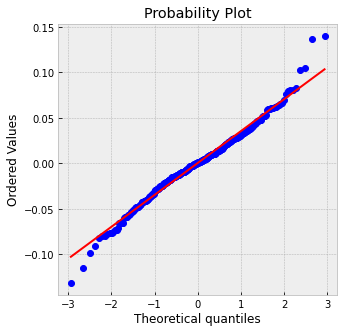

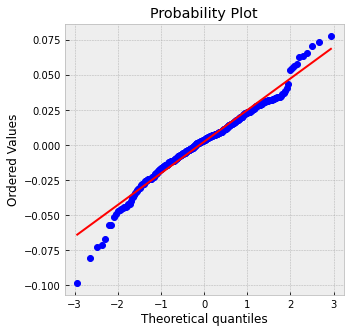

In [59]:
for col in cols:
    qqplot(train_df[col].diff(1).fillna(0))

<AxesSubplot:xlabel='Date'>

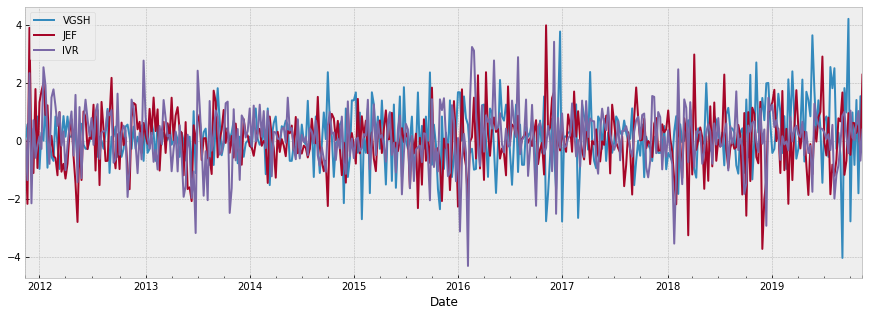

In [60]:
train_df[cols].diff(1).fillna(0).apply(lambda x: x / x.std()).plot(
    figsize=(15,5)
)

array([<AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>], dtype=object)

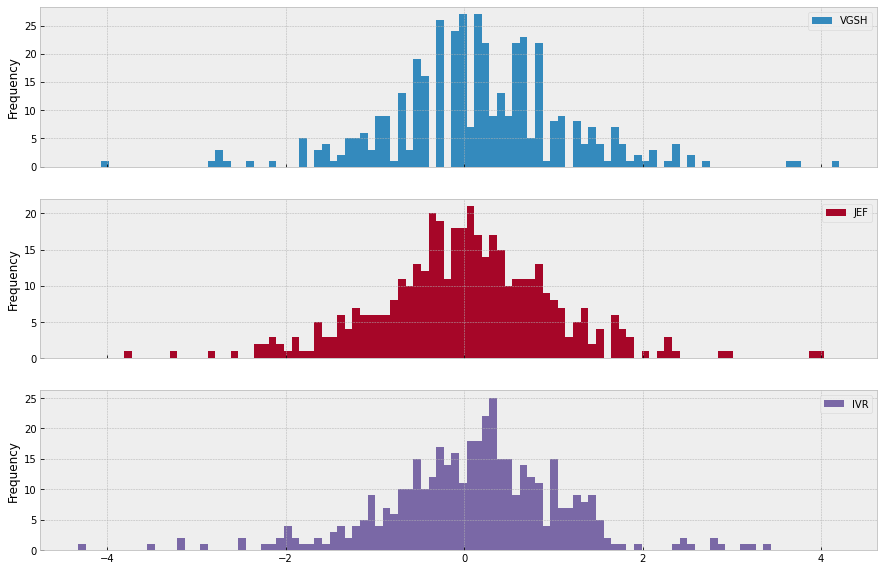

In [61]:
train_df[cols].diff(1).fillna(0).apply(lambda x: x / x.std()).plot(
    subplots=True, kind='hist', bins=100,
    figsize=(15,10)
)

In [62]:
company_df = pd.read_csv(os.path.join(Config.input_path, 'company_list.csv')).rename(columns={'Symbol':'id'})
print(company_df.shape)

(7007, 6)


In [63]:
display(company_df)
company_df.info()

,id,Name,IPOyear,Sector,Industry,List
0,XXII,"22nd Century Group, Inc",NaN,Consumer Non-Durables,Farming/Seeds/Milling,AMEX
1,FAX,Aberdeen Asia-Pacific Income Fund Inc,1986.0,NaN,NaN,AMEX
2,IAF,Aberdeen Australia Equity Fund Inc,NaN,NaN,NaN,AMEX
3,AEF,"Aberdeen Emerging Markets Equity Income Fund, ...",NaN,NaN,NaN,AMEX
4,FCO,"Aberdeen Global Income Fund, Inc.",1992.0,NaN,NaN,AMEX
...,...,...,...,...,...,...
7002,ZBH,"Zimmer Biomet Holdings, Inc.",NaN,Health Care,Industrial Specialties,NYSE
7003,ZTS,Zoetis Inc.,2013.0,Health Care,Major Pharmaceuticals,NYSE
7004,ZTO,ZTO Express (Cayman) Inc.,2016.0,Transportation,Trucking Freight/Courier Services,NYSE
7005,ZUO,"Zuora, Inc.",2018.0,Technology,Computer Software: Prepackaged Software,NYSE


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7007 entries, 0 to 7006
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        7007 non-null   object 
 1   Name      7007 non-null   object 
 2   IPOyear   3211 non-null   float64
 3   Sector    5347 non-null   object 
 4   Industry  5347 non-null   object 
 5   List      7007 non-null   object 
dtypes: float64(1), object(5)
memory usage: 328.6+ KB


In [64]:
not_exist = list(train_df.columns[~train_df.columns.isin(company_df['id'])])
print(not_exist)

['SPB', 'SAND', 'GEN', 'STAR']


In [65]:
for col in not_exist:
    company_df = company_df.append({'id':col}, ignore_index=True)

In [66]:
company_df = company_df[company_df['id'].isin(train_df.columns)]
print(len(company_df))

3287


In [67]:
company_df[company_df.duplicated(subset='id', keep=False)].sort_values('id')

,id,Name,IPOyear,Sector,Industry,List
487,AMOV,"America Movil, S.A.B. de C.V.",NaN,Public Utilities,Telecommunications Equipment,NASDAQ
4033,AMOV,"America Movil, S.A.B. de C.V.",NaN,Public Utilities,Telecommunications Equipment,NYSE
73,CDOR,"Condor Hospitality Trust, Inc.",NaN,Consumer Services,Real Estate Investment Trusts,AMEX
1072,CDOR,"Condor Hospitality Trust, Inc.",NaN,Consumer Services,Real Estate Investment Trusts,NASDAQ
1077,CNMD,CONMED Corporation,NaN,Health Care,Biotechnology: Electromedical & Electrotherape...,NASDAQ
4679,CNMD,CONMED Corporation,NaN,Health Care,Biotechnology: Electromedical & Electrotherape...,NYSE
315,EGHT,8x8 Inc,NaN,Technology,EDP Services,NASDAQ
3917,EGHT,8x8 Inc,NaN,Technology,EDP Services,NYSE
701,GOLD,Barrick Gold Corporation,NaN,Basic Industries,Precious Metals,NASDAQ
4264,GOLD,Barrick Gold Corporation,NaN,Basic Industries,Precious Metals,NYSE


In [68]:
company_df['List1'] = company_df[['id', 'List']].groupby('id').transform(lambda x: x.iloc[0])
company_df['List2'] = company_df[['id', 'List']].groupby('id').transform(lambda x: x.iloc[-1])
company_df = company_df.drop('List', axis=1).drop_duplicates(subset='id').reset_index(drop=True)
display(company_df)
company_df.info()

,id,Name,IPOyear,Sector,Industry,List1,List2
0,XXII,"22nd Century Group, Inc",NaN,Consumer Non-Durables,Farming/Seeds/Milling,AMEX,AMEX
1,FAX,Aberdeen Asia-Pacific Income Fund Inc,1986.0,NaN,NaN,AMEX,AMEX
2,IAF,Aberdeen Australia Equity Fund Inc,NaN,NaN,NaN,AMEX,AMEX
3,AEF,"Aberdeen Emerging Markets Equity Income Fund, ...",NaN,NaN,NaN,AMEX,AMEX
4,FCO,"Aberdeen Global Income Fund, Inc.",1992.0,NaN,NaN,AMEX,AMEX
...,...,...,...,...,...,...,...
3273,ZBH,"Zimmer Biomet Holdings, Inc.",NaN,Health Care,Industrial Specialties,NYSE,NYSE
3274,SPB,NaN,NaN,NaN,NaN,NaN,NaN
3275,SAND,NaN,NaN,NaN,NaN,NaN,NaN
3276,GEN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3278 entries, 0 to 3277
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        3278 non-null   object 
 1   Name      3274 non-null   object 
 2   IPOyear   1083 non-null   float64
 3   Sector    2732 non-null   object 
 4   Industry  2732 non-null   object 
 5   List1     3274 non-null   object 
 6   List2     3274 non-null   object 
dtypes: float64(1), object(6)
memory usage: 179.4+ KB


In [69]:
train_df.loc[pd.to_datetime('2019-11-24'), :] = np.nan
train_date = pd.Series(train_df.index)
train_df.reset_index(drop=True, inplace=True)

In [70]:
train_df

,VGSH,JEF,IVZ,KTCC,FBZ,PLOW,JBK,IAC,IVR,VSH,VCV,OKE,ROK,FTAG,BRKR,GSK,JPS,SRPT,VMI,IMKTA,BDR,JAKK,MVC,AMSF,APTO,...,FRAF,HWCC,WYND,CHMG,EVC,NNA,IOR,ATLC,STWD,TTM,NOC,EQS,MKC,MXL,NEV,ASFI,JTA,MNR,TFSL,GTN,TYG,VIRC,BIS,WOOD,MASI
0,4.042036,2.925793,2.692657,1.752672,2.695899,2.415770,2.598276,3.675911,1.764089,2.259204,2.183476,3.182221,4.099904,4.445627,2.544092,3.376687,1.642533,1.768150,4.331112,2.573406,0.756122,2.968169,2.164822,2.784685,1.355835,...,2.483955,2.374750,2.424196,2.915230,0.731487,3.540860,1.071584,1.425515,2.055475,2.823248,3.882439,1.166271,3.736447,1.785070,2.246080,1.552140,1.748773,1.882177,2.111697,1.029619,3.048279,0.917934,6.718732,3.463178,2.966834
1,4.042680,2.849009,2.618837,1.781709,2.620614,2.401097,2.569965,3.617720,1.733084,2.158403,2.190471,3.158724,4.038132,4.376117,2.506505,3.335931,1.623867,1.625311,4.261818,2.508207,0.760806,2.915700,2.078407,2.740216,1.258461,...,2.496266,2.276346,2.405357,2.917288,0.580733,3.449779,0.982078,1.523880,2.014695,2.805253,3.832284,1.141033,3.721543,1.749200,2.256364,1.524042,1.713638,1.867705,2.095011,0.940007,3.030702,0.906086,6.647476,3.414801,2.919635
2,4.043420,2.986361,2.734559,1.761300,2.702577,2.443254,2.586689,3.700802,1.786195,2.262921,2.185579,3.223009,4.145369,4.468431,2.602308,3.396349,1.647657,1.637053,4.364907,2.559964,0.832909,2.951317,2.161913,2.828451,1.223775,...,2.474622,2.361495,2.483775,2.919342,0.731487,3.489330,0.879627,1.611436,2.029451,2.933184,3.895617,1.150572,3.748533,1.798404,2.255723,1.527965,1.766736,1.852033,2.153634,0.993252,3.077226,0.945044,6.512062,3.488089,3.026797
3,4.043099,2.966576,2.757351,1.745716,2.707654,2.455502,2.576326,3.685288,1.737013,2.241358,2.199493,3.227504,4.182269,4.452777,2.605927,3.406795,1.656814,1.660131,4.376419,2.558117,0.788457,2.966694,2.172058,2.818489,1.187843,...,2.442867,2.427547,2.489384,2.919342,0.813372,3.599384,0.850151,1.648659,2.068706,2.916030,3.885423,1.147402,3.768749,1.790091,2.262103,1.513174,1.780209,1.871585,2.122347,1.007958,3.045037,1.022226,6.545216,3.483629,3.014715
4,4.043581,2.927262,2.685418,1.713798,2.670351,2.437973,2.569053,3.679438,1.753126,2.165585,2.207543,3.210689,4.108152,4.370054,2.566134,3.411762,1.652250,1.472472,4.366758,2.561807,0.788457,2.872486,2.134596,2.808832,1.150572,...,2.341062,2.479791,2.457613,2.955605,0.812461,3.541997,0.792993,1.623341,2.089152,2.799378,3.872489,1.211941,3.748332,1.690096,2.266674,1.521090,1.746472,1.896444,2.074007,1.007958,3.060401,0.831893,6.556676,3.447220,2.954994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,4.117700,2.988396,2.870108,1.941615,2.789991,3.892326,3.401197,5.440511,2.694665,3.040660,2.585287,4.254037,5.174940,3.186944,3.932148,3.809911,2.379226,4.495020,4.949199,3.705755,0.553885,0.559616,2.273710,4.187055,1.147402,...,3.615006,1.686399,3.841426,3.775193,1.315314,2.086360,2.573375,2.186051,3.179730,2.593761,5.859469,0.932164,5.081718,3.031582,2.728786,2.073172,2.489668,2.760995,2.997891,2.880882,2.933238,1.611436,2.847909,4.176479,5.000652
416,4.115598,3.007601,2.919259,1.978239,2.746074,3.970133,3.433987,5.397936,2.717968,3.017693,2.587507,4.257260,5.181324,3.216963,3.888142,3.791380,2.375619,4.577593,4.960882,3.782356,0.500775,0.620576,2.291730,4.206203,1.214913,...,3.616340,1.619388,3.894253,3.831941,1.338155,1.969776,2.549445,2.071913,3.174609,2.554122,5.853733,0.940007,5.075885,3.058707,2.732622,2.406945,2.501457,2.733430,3.005154,3.043570,2.903785,1.627278,2.838054,4.190177,4.969466
417,4.117377,2.994112,2.899421,1.940179,2.755359,3.976613,3.384390,5.406364,2.702298,3.011868,2.587725,4.268526,5.299589,3.198408,3.919941,3.795092,2.382372,4.589650,4.955442,3.803015,0.500775,0.641854,2.286757,4.188550,1.217876,...,3.603186,1.611436,3.869812,3.816486,1.270694,1.987287,2.549445,2.137710,3.163887,2.554122,5.872215,0.928219,5.092487,3.046901,2.730484,2

In [27]:
train_df = train_df.T.reset_index().rename(columns={'index': 'id'})
train_df = pd.melt(
    train_df, id_vars='id', value_vars=[week for week in range(420)],
    var_name='Week', value_name='y'
)
display(train_df)
train_df.info()

,id,Week,y
0,VGSH,0,4.042036
1,JEF,0,2.925793
2,IVZ,0,2.692657
3,KTCC,0,1.752672
4,FBZ,0,2.695899
...,...,...,...
1376755,TYG,419,NaN
1376756,VIRC,419,NaN
1376757,BIS,419,NaN
1376758,WOOD,419,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1376760 entries, 0 to 1376759
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   id      1376760 non-null  object 
 1   Week    1376760 non-null  object 
 2   y       1373482 non-null  float64
dtypes: float64(1), object(2)
memory usage: 31.5+ MB


In [28]:
train_df['y_prev'] = train_df[['id', 'y']].groupby('id')['y'].transform(lambda x: x.shift(1).fillna(method='bfill'))
train_df['y_diff'] = train_df['y'] - train_df['y_prev']
train_df['y_diff_std'] = train_df[['id', 'y']].groupby('id')['y'].transform(lambda x: x.std())
train_df['y_diff_norm'] = train_df['y_diff'] / train_df['y_diff_std']

In [29]:
train_df['Year'] = train_df['Week'].map(train_date).dt.year
train_df['Month'] = train_df['Week'].map(train_date).dt.month
train_df['Day'] = train_df['Week'].map(train_date).dt.day
train_df['WeekOfYear'] = train_df['Week'].map(train_date).dt.isocalendar().week.astype(int)

In [30]:
train_df = pd.merge(train_df, company_df, on='id', how='left')
display(train_df)
train_df.info()

,id,Week,y,y_prev,y_diff,y_diff_std,y_diff_norm,Year,Month,Day,WeekOfYear,Name,IPOyear,Sector,Industry,List1,List2
0,VGSH,0,4.042036,4.042036,0.0,0.017516,0.0,2011,11,13,45,Vanguard Short-Term Treasury ETF,NaN,NaN,NaN,NASDAQ,NASDAQ
1,JEF,0,2.925793,2.925793,0.0,0.141216,0.0,2011,11,13,45,Jefferies Financial Group Inc.,NaN,Finance,Investment Bankers/Brokers/Service,NYSE,NYSE
2,IVZ,0,2.692657,2.692657,0.0,0.215237,0.0,2011,11,13,45,Invesco Plc,NaN,Finance,Investment Managers,NYSE,NYSE
3,KTCC,0,1.752672,1.752672,0.0,0.207799,0.0,2011,11,13,45,Key Tronic Corporation,1983.0,Technology,Computer peripheral equipment,NASDAQ,NASDAQ
4,FBZ,0,2.695899,2.695899,0.0,0.224060,0.0,2011,11,13,45,First Trust Brazil AlphaDEX Fund,NaN,NaN,NaN,NASDAQ,NASDAQ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1376755,TYG,419,NaN,2.884177,NaN,0.141783,NaN,2019,11,24,47,Tortoise Energy Infrastructure Corporation,2004.0,NaN,NaN,NYSE,NYSE
1376756,VIRC,419,NaN,1.543298,NaN,0.264580,NaN,2019,11,24,47,Virco Manufacturing Corporation,NaN,Consumer Durables,Industrial Specialties,NASDAQ,NASDAQ
1376757,BIS,419,NaN,2.754241,NaN,1.087817,NaN,2019,11,24,47,ProShares UltraShort Nasdaq Biotechnology,NaN,NaN,NaN,NASDAQ,NASDAQ
1376758,WOOD,419,NaN,4.184112,NaN,0.225542,NaN,2019,11,24,47,iShares S&P Global Timber & Forestry Index Fund,NaN,NaN,NaN,NASDAQ,NASDAQ


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1376760 entries, 0 to 1376759
Data columns (total 17 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   id           1376760 non-null  object 
 1   Week         1376760 non-null  object 
 2   y            1373482 non-null  float64
 3   y_prev       1376760 non-null  float64
 4   y_diff       1373482 non-null  float64
 5   y_diff_std   1376760 non-null  float64
 6   y_diff_norm  1373482 non-null  float64
 7   Year         1376760 non-null  int64  
 8   Month        1376760 non-null  int64  
 9   Day          1376760 non-null  int64  
 10  WeekOfYear   1376760 non-null  int64  
 11  Name         1375080 non-null  object 
 12  IPOyear      454860 non-null   float64
 13  Sector       1147440 non-null  object 
 14  Industry     1147440 non-null  object 
 15  List1        1375080 non-null  object 
 16  List2        1375080 non-null  object 
dtypes: float64(6), int64(4), object(7)
memory usag

In [31]:
train_df['enc_Sector'] = LabelEncoder().fit_transform(train_df['Sector'].fillna('nothing'))
train_df['enc_Industry'] = LabelEncoder().fit_transform(train_df['Industry'].fillna('nothing'))
train_df['enc_List1'] = LabelEncoder().fit_transform(train_df['List1'].fillna('nothing'))
train_df['enc_List2'] = LabelEncoder().fit_transform(train_df['List2'].fillna('nothing'))

In [32]:
def create_lags(df, group_col, val_col, lags):
    lag_df = pd.DataFrame()
    for lag in lags:
        lag_df[f'lag_{lag}_{val_col}'] = df[[group_col, val_col]].groupby(
            group_col)[val_col].transform(lambda x: x.shift(lag))
    return lag_df

lag_df = create_lags(train_df, 'id', 'y_diff_norm', [1,2,3,4])
display(lag_df)
lag_df.info()

,lag_1_y_diff_norm,lag_2_y_diff_norm,lag_3_y_diff_norm,lag_4_y_diff_norm
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
...,...,...,...,...
1376755,-0.087223,-0.051072,-0.207735,0.031837
1376756,-0.196693,-0.120716,0.059876,0.037910
1376757,-0.059202,-0.017845,-0.009060,-0.071397
1376758,-0.047620,0.020729,0.060736,0.044388


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1376760 entries, 0 to 1376759
Data columns (total 4 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   lag_1_y_diff_norm  1373482 non-null  float64
 1   lag_2_y_diff_norm  1370204 non-null  float64
 2   lag_3_y_diff_norm  1366926 non-null  float64
 3   lag_4_y_diff_norm  1363648 non-null  float64
dtypes: float64(4)
memory usage: 52.5 MB


In [33]:
def create_rolls(df, group_col, val_col, lags, rolls):
    roll_df = pd.DataFrame()
    for lag in lags:
        for roll in rolls:
            roll_df[f'rmean_{lag}_{val_col}'] = df[[group_col, val_col]].groupby(
                group_col)[val_col].transform(lambda x: x.shift(lag).rolling(roll).mean())
            roll_df[f'rstd_{lag}_{val_col}'] = df[[group_col, val_col]].groupby(
                group_col)[val_col].transform(lambda x: x.shift(lag).rolling(roll).std())
    return roll_df

roll_df = create_rolls(train_df, 'id', 'y_diff_norm', [1], [4, 9, 13, 26, 52])
display(roll_df)
roll_df.info()

,rmean_1_y_diff_norm,rstd_1_y_diff_norm
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
1376755,-0.018841,0.221444
1376756,-0.010175,0.153233
1376757,-0.005512,0.064397
1376758,0.004269,0.127733


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1376760 entries, 0 to 1376759
Data columns (total 2 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   rmean_1_y_diff_norm  1206304 non-null  float64
 1   rstd_1_y_diff_norm   1206304 non-null  float64
dtypes: float64(2)
memory usage: 31.5 MB


In [34]:
train_df = pd.concat([train_df, lag_df, roll_df], axis=1)
display(train_df)
train_df.info()

,id,Week,y,y_prev,y_diff,y_diff_std,y_diff_norm,Year,Month,Day,WeekOfYear,Name,IPOyear,Sector,Industry,List1,List2,enc_Sector,enc_Industry,enc_List1,enc_List2,lag_1_y_diff_norm,lag_2_y_diff_norm,lag_3_y_diff_norm,lag_4_y_diff_norm,rmean_1_y_diff_norm,rstd_1_y_diff_norm
0,VGSH,0,4.042036,4.042036,0.0,0.017516,0.0,2011,11,13,45,Vanguard Short-Term Treasury ETF,NaN,NaN,NaN,NASDAQ,NASDAQ,12,134,1,1,NaN,NaN,NaN,NaN,NaN,NaN
1,JEF,0,2.925793,2.925793,0.0,0.141216,0.0,2011,11,13,45,Jefferies Financial Group Inc.,NaN,Finance,Investment Bankers/Brokers/Service,NYSE,NYSE,6,64,2,2,NaN,NaN,NaN,NaN,NaN,NaN
2,IVZ,0,2.692657,2.692657,0.0,0.215237,0.0,2011,11,13,45,Invesco Plc,NaN,Finance,Investment Managers,NYSE,NYSE,6,65,2,2,NaN,NaN,NaN,NaN,NaN,NaN
3,KTCC,0,1.752672,1.752672,0.0,0.207799,0.0,2011,11,13,45,Key Tronic Corporation,1983.0,Technology,Computer peripheral equipment,NASDAQ,NASDAQ,10,31,1,1,NaN,NaN,NaN,NaN,NaN,NaN
4,FBZ,0,2.695899,2.695899,0.0,0.224060,0.0,2011,11,13,45,First Trust Brazil AlphaDEX Fund,NaN,NaN,NaN,NASDAQ,NASDAQ,12,134,1,1,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1376755,TYG,419,NaN,2.884177,NaN,0.141783,NaN,2019,11,24,47,Tortoise Energy Infrastructure Corporation,2004.0,NaN,NaN,NYSE,NYSE,12,134,2,2,-0.087223,-0.051072,-0.207735,0.031837,-0.018841,0.221444
1376756,VIRC,419,NaN,1.543298,NaN,0.264580,NaN,2019,11,24,47,Virco Manufacturing Corporation,NaN,Consumer Durables,Industrial Specialties,NASDAQ,NASDAQ,2,62,1,1,-0.196693,-0.120716,0.059876,0.037910,-0.010175,0.153233
1376757,BIS,419,NaN,2.754241,NaN,1.087817,NaN,2019,11,24,47,ProShares UltraShort Nasdaq Biotechnology,NaN,NaN,NaN,NASDAQ,NASDAQ,12,134,1,1,-0.059202,-0.017845,-0.009060,-0.071397,-0.005512,0.064397
1376758,WOOD,419,NaN,4.184112,NaN,0.225542,NaN,2019,11,24,47,iShares S&P Global Timber & Forestry Index Fund,NaN,NaN,NaN,NASDAQ,NASDAQ,12,134,1,1,-0.047620,0.020729,0.060736,0.044388,0.004269,0.127733


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1376760 entries, 0 to 1376759
Data columns (total 27 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   id                   1376760 non-null  object 
 1   Week                 1376760 non-null  object 
 2   y                    1373482 non-null  float64
 3   y_prev               1376760 non-null  float64
 4   y_diff               1373482 non-null  float64
 5   y_diff_std           1376760 non-null  float64
 6   y_diff_norm          1373482 non-null  float64
 7   Year                 1376760 non-null  int64  
 8   Month                1376760 non-null  int64  
 9   Day                  1376760 non-null  int64  
 10  WeekOfYear           1376760 non-null  int64  
 11  Name                 1375080 non-null  object 
 12  IPOyear              454860 non-null   float64
 13  Sector               1147440 non-null  object 
 14  Industry             1147440 non-null  object 
 15

In [35]:
test_df = train_df.loc[train_df['Week'] == 419].reset_index(drop=True)
train_df = train_df.loc[train_df['Week'] < 419].reset_index(drop=True)

useless_cols = [
    'y', 'y_prev', 'y_diff', 'y_diff_std', 'y_diff_norm',
    'Week', 'id', 'Name', 'Sector', 'Industry', 'List1', 'List2'
]
usable_cols = train_df.columns[~train_df.columns.isin(useless_cols)]
target_col = 'y_diff_norm'

x_train = train_df[usable_cols]
y_train = train_df[target_col]
x_test = test_df[usable_cols]

In [36]:
train_df.columns

Index(['id', 'Week', 'y', 'y_prev', 'y_diff', 'y_diff_std', 'y_diff_norm',
       'Year', 'Month', 'Day', 'WeekOfYear', 'Name', 'IPOyear', 'Sector',
       'Industry', 'List1', 'List2', 'enc_Sector', 'enc_Industry', 'enc_List1',
       'enc_List2', 'lag_1_y_diff_norm', 'lag_2_y_diff_norm',
       'lag_3_y_diff_norm', 'lag_4_y_diff_norm', 'rmean_1_y_diff_norm',
       'rstd_1_y_diff_norm'],
      dtype='object')

In [37]:
col = ['id','Year', 'Month', 'Day', 'lag_1_y_diff_norm', 'lag_2_y_diff_norm',
       'lag_3_y_diff_norm', 'lag_4_y_diff_norm', 'rmean_1_y_diff_norm',
       'rstd_1_y_diff_norm']

train_df[col].to_csv('preprocess_notebook.csv')

In [38]:
lgb_params = {
    'objective': 'regression',
    'importance_type': 'gain',
    'metric': 'rmse',
    'seed': Config.seed,
    'n_jobs': -1,
    'verbose': -1,

    'n_estimators': 500, 'learning_rate': 0.1,
    'boosting_type': 'gbdt',
    'subsample': 0.5, 'subsample_freq': 1,
    'colsample_bytree': 0.5,
    'num_leaves': 127, 'min_child_samples': 255,
    'max_bin': 100,
}

In [39]:
train_df

,id,Week,y,y_prev,y_diff,y_diff_std,y_diff_norm,Year,Month,Day,WeekOfYear,Name,IPOyear,Sector,Industry,List1,List2,enc_Sector,enc_Industry,enc_List1,enc_List2,lag_1_y_diff_norm,lag_2_y_diff_norm,lag_3_y_diff_norm,lag_4_y_diff_norm,rmean_1_y_diff_norm,rstd_1_y_diff_norm
0,VGSH,0,4.042036,4.042036,0.000000,0.017516,0.000000,2011,11,13,45,Vanguard Short-Term Treasury ETF,NaN,NaN,NaN,NASDAQ,NASDAQ,12,134,1,1,NaN,NaN,NaN,NaN,NaN,NaN
1,JEF,0,2.925793,2.925793,0.000000,0.141216,0.000000,2011,11,13,45,Jefferies Financial Group Inc.,NaN,Finance,Investment Bankers/Brokers/Service,NYSE,NYSE,6,64,2,2,NaN,NaN,NaN,NaN,NaN,NaN
2,IVZ,0,2.692657,2.692657,0.000000,0.215237,0.000000,2011,11,13,45,Invesco Plc,NaN,Finance,Investment Managers,NYSE,NYSE,6,65,2,2,NaN,NaN,NaN,NaN,NaN,NaN
3,KTCC,0,1.752672,1.752672,0.000000,0.207799,0.000000,2011,11,13,45,Key Tronic Corporation,1983.0,Technology,Computer peripheral equipment,NASDAQ,NASDAQ,10,31,1,1,NaN,NaN,NaN,NaN,NaN,NaN
4,FBZ,0,2.695899,2.695899,0.000000,0.224060,0.000000,2011,11,13,45,First Trust Brazil AlphaDEX Fund,NaN,NaN,NaN,NASDAQ,NASDAQ,12,134,1,1,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1373477,TYG,418,2.884177,2.896544,-0.012367,0.141783,-0.087223,2019,11,17,46,Tortoise Energy Infrastructure Corporation,2004.0,NaN,NaN,NYSE,NYSE,12,134,2,2,-0.051072,-0.207735,0.031837,-0.052981,-0.021131,0.222777
1373478,VIRC,418,1.543298,1.595339,-0.052041,0.264580,-0.196693,2019,11,17,46,Virco Manufacturing Corporation,NaN,Consumer Durables,Industrial Specialties,NASDAQ,NASDAQ,2,62,1,1,-0.120716,0.059876,0.037910,0.000000,-0.006123,0.150973
1373479,BIS,418,2.754241,2.818641,-0.064401,1.087817,-0.059202,2019,11,17,46,ProShares UltraShort Nasdaq Biotechnology,NaN,NaN,NaN,NASDAQ,NASDAQ,12,134,1,1,-0.017845,-0.009060,-0.071397,-0.053839,-0.003833,0.064107
1373480,WOOD,418,4.184112,4.194853,-0.010740,0.225542,-0.047620,2019,11,17,46,iShares S&P Global Timber & Forestry Index Fund,NaN,NaN,NaN,NASDAQ,NASDAQ,12,134,1,1,0.020729,0.060736,0.044388,0.171420,0.002908,0.128671


In [40]:
# timeseriessplitを使う
id_count = len(train_df['id'].unique())
tscv = TimeSeriesSplit(n_splits=5, test_size=id_count)
train_df_sort = train_df.sort_values(by=['Year','Month','Day'])
x_train_sort = train_df_sort[usable_cols]
y_train_sort = train_df_sort[target_col]

In [43]:
x_train_sort.to_csv('preprocess_x.csv', index=False)
y_train_sort.to_csv('preprocess_y.csv', index=False)

In [42]:
y_diff_std = train_df['y_diff_std']
groups = train_df['id']
y_oof = np.zeros(len(y_train))
y_preds = []
kf = GroupKFold(n_splits=5)
# for fold, (tr_idx, vl_idx) in enumerate(kf.split(x_train, y_train, groups)):
for fold, (tr_idx, vl_idx) in enumerate(tscv.split(x_train_sort, y_train_sort)):
    x_tr_fold = x_train.iloc[tr_idx]
    y_tr_fold = y_train.iloc[tr_idx]
    x_vl_fold = x_train.iloc[vl_idx]
    y_vl_fold = y_train.iloc[vl_idx]

    model = lgb.LGBMRegressor(**lgb_params)
    model.fit(
        x_tr_fold, y_tr_fold,
        eval_set=(x_vl_fold, y_vl_fold),
        eval_metric='rmse',
        verbose=False,
        early_stopping_rounds=100,
    )

    y_oof[vl_idx] = model.predict(x_vl_fold)
    y_preds.append(model.predict(x_test))

    print(
        f'fold {fold} score:',
        np.sqrt(np.mean(np.square((y_oof[vl_idx] - y_vl_fold) * y_diff_std[vl_idx])))
    )

print(
    'oof score:',
    np.sqrt(np.mean(np.square((y_oof[vl_idx] - y_vl_fold) * y_diff_std[vl_idx])))
)

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


fold 0 score: 0.04722062707168566
fold 1 score: 0.05072458820477662
fold 2 score: 0.06426384500340823
fold 3 score: 0.048114102778403806
fold 4 score: 0.04355957825511097
oof score: 0.04355957825511097


In [66]:
submission_df = pd.read_csv(os.path.join(Config.input_path, 'submission_template.csv'))
submission_df['y'] = np.expm1(
    np.mean(y_preds, axis=0) * test_df['y_diff_std'].values + test_df['y_prev'].values
)
submission_df.to_csv(os.path.join(Config.result_path, 'submission.csv'), index=False)